# Stable nitrogen isotope analyis of Chagos rat dataset

The models here will be run in [Python](https://www.python.org), using the [PyMC3 package](https://github.com/pymc-devs/pymc3).

### Data wrangling

The first step is to instantiate the various python packages needed for the analysis:

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
from scipy.stats import gaussian_kde
import pymc3 as pm
import theano.tensor as tt
import matplotlib as mp
import os

# Return list of unique items and an index of their position in L
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Return list of unique items and an index of their position in long, relative to short
def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Path to plot storage
plotdir = os.getcwd()+'/plots'

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import age and growth data
xdata = pd.read_csv('Chagos_isotope_data.csv')
xdata.head()

,Tissue,Atoll,Island,TNI_reef_area,Reef_area,To_shore_m,Treatment,cal_d13C,cal_perc_C,cal_d15N,cal_perc_N,CN_ratio
0,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-15.65,44.68,10.55,13.78,3.24
1,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-16.45,41.73,10.40,12.92,3.23
2,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-15.39,44.64,10.76,14.04,3.18
3,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-15.73,45.28,10.94,14.15,3.20
4,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-16.72,45.12,10.90,14.01,3.22


In [3]:
xdata.Island.unique()

array(['Eagle', 'Middle_Brother', 'South_Brother',
       'Grande_Ile_Coquillage', 'Grande_Ile_Mapou', 'Ile_Longue',
       'Ile_Poule', 'PB_Ile_Anglaise', 'Ile_de_la_Passe', 'Ile_Fouquet',
       'Sal_Ile_Anglaise', 'Nelson_Island'], dtype=object)

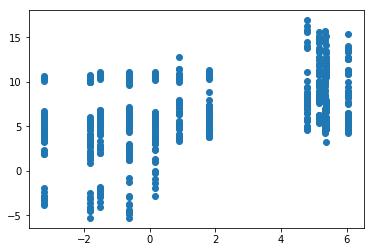

In [4]:
plt.scatter(np.log(xdata.TNI_reef_area),xdata.cal_d15N)

In [5]:
# Make arrays locally available
organism = xdata.Tissue.values
Organism,Io = indexall(organism)
norg = len(Organism)

It = xdata.Treatment.values=='Rats'

atoll = xdata.Atoll.values
island = xdata.Island.values

Atoll,Ia = subindexall(atoll,island)
natoll = len(Atoll)
Island,Is = indexall(island)
nisland = len(Island)
TNI = np.log(np.array([xdata.TNI_reef_area[list(island).index(i)] for i in Island]))
ReefArea = np.log(np.array([xdata.Reef_area[list(island).index(i)] for i in Island]))

# Distance to shore in metres 
Dshore_ = xdata.To_shore_m.values
Dshore_[np.isnan(Dshore_)] = 0
Dshore = stdize(Dshore_)
Dshore[Dshore<0] = 0

d15N = xdata.cal_d15N.values

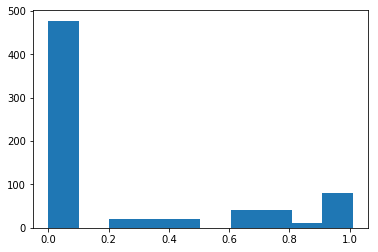

In [6]:
plt.hist(Dshore);

In [7]:
island[((organism=="Leaves")*(It==1)*(d15N>0))==1]

array(['Grande_Ile_Mapou', 'Grande_Ile_Mapou', 'Grande_Ile_Mapou',
       'Ile_Fouquet', 'Ile_Fouquet', 'Ile_Fouquet', 'Ile_Fouquet',
       'Ile_Fouquet', 'Ile_Fouquet', 'Ile_Fouquet', 'Ile_Fouquet',
       'Ile_Fouquet', 'Ile_Fouquet'], dtype=object)

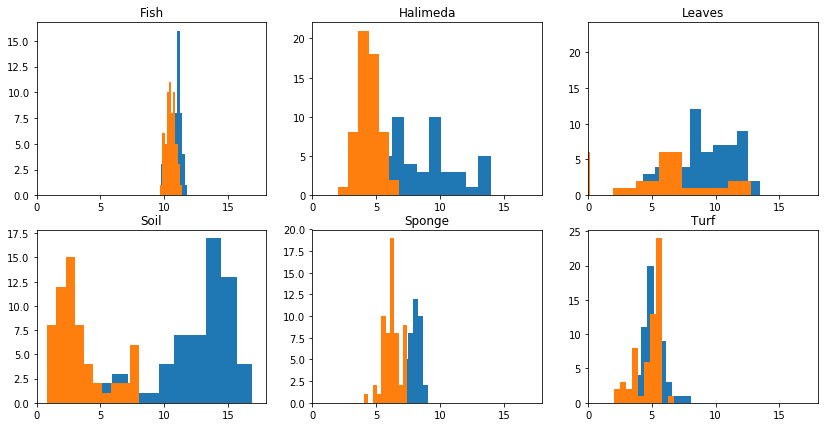

In [8]:
# Larger biplots
fig = plt.figure(figsize=(14, 7))
gs = mp.gridspec.GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])
axlist = [ax1,ax2,ax3,ax4,ax5,ax6]

title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

for i in range(norg):
    ogx = Organism[i]
    tmp = d15N[organism==ogx]
    tmp2 = It[organism==ogx]
    ax = axlist[i]
    ax.hist(tmp[tmp2==0])
    ax.hist(tmp[tmp2==1])
    ax.set_xlim(0,18)
    ax.set_title(ogx)
    

In [9]:
Organism

['Fish', 'Halimeda', 'Leaves', 'Soil', 'Sponge', 'Turf']

# Build Bayesian Model

In [10]:
Model = pm.Model()

with Model:

    # Global prior
    γ0 = pm.Normal('Mean_d15N', mu=0.0, tau=0.001)
    # Reef-area effect
    #γ1 = pm.Normal('ReefArea', mu=0.0, tau=0.001)
    
    # Island-level model
    #γ = γ0+γ1*ReefArea
    γ = γ0
    # Inter-island variablity
    σγ = pm.Uniform('SD_reef', lower=0, upper=100)
    τγ = σγ**-2
    β0 = pm.Normal('Island_d15N', mu=γ, tau=τγ, shape=nisland)

    # Organism mean (no rats)
    β1_ = pm.Normal('Organism_', mu=0.0, tau=0.001, shape=norg-1)
    β1 = tt.set_subtensor(tt.zeros(shape=norg)[1:], β1_)

    # Organism-specific rat effects
    β2 = pm.Normal('Rat_effect_', mu=0.0, tau=0.001, shape=norg)

    # Distance to shore
    β3 = pm.Normal('Dist_to_shore', mu=0.0, tau=0.001)

    # Mean model
    μ = β0[Is]+β1[Io]+β2[Io]*It+β3*Dshore

    # Organism-specific variance
    σ = pm.Uniform('SD', lower=0, upper=100)
    τ = σ**-2

    # Likelihood
    Yi = pm.StudentT('Yi', nu=4, mu=μ, lam=τ, observed=d15N)

In [11]:
# Sampling
with Model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 5500/5500 [00:46<00:00, 118.82it/s]


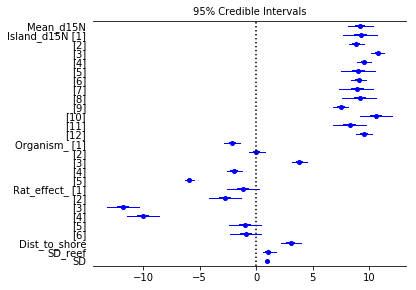

In [12]:
pm.forestplot(trace);

In [13]:
pm.stats.summary(trace);


Mean_d15N:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.232            0.560            0.015            [8.146, 10.345]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.122          8.869          9.242          9.595          10.331


Island_d15N:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.261            0.749            0.020            [7.714, 10.719]
  8.853            0.347            0.010            [8.193, 9.541]
  10.793           0.295            0.009            [10.211, 11.354]
  9.547            0.304            0.009            [8.945, 10.147]
  9.061            0.754            0.021            [7.533, 10.569]
  9.075            0.339            0.010   

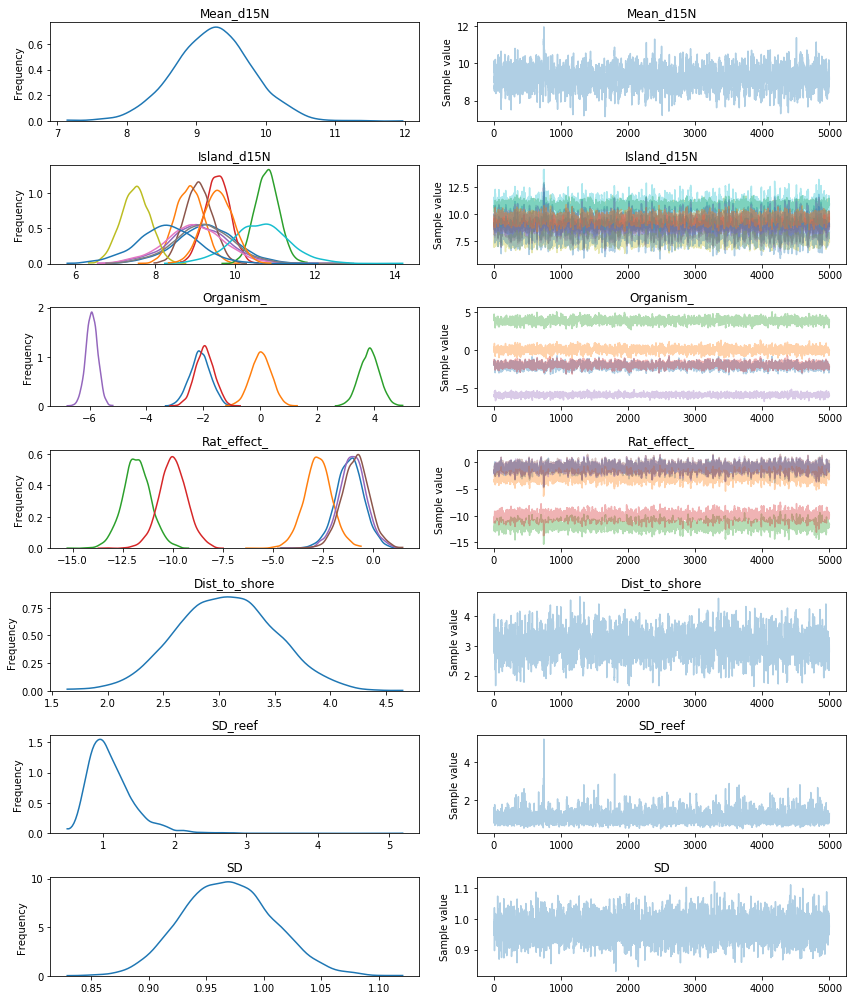

In [14]:
pm.traceplot(trace);

In [15]:
trace.varnames

['Mean_d15N',
 'SD_reef_interval__',
 'Island_d15N',
 'Organism_',
 'Rat_effect_',
 'Dist_to_shore',
 'SD_interval__',
 'SD_reef',
 'SD']

## Rat effect sizes

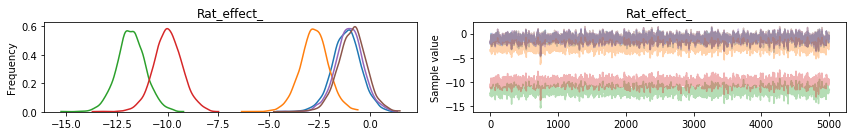

In [16]:
pm.traceplot(trace, ['Rat_effect_']);

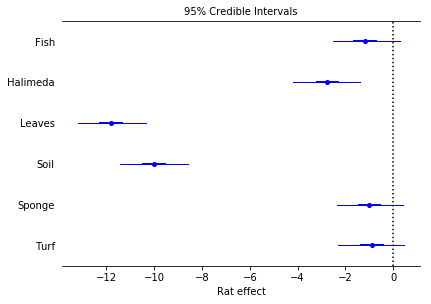

In [17]:
pm.forestplot(trace, ['Rat_effect_'], ylabels=Organism, xtitle='Rat effect');

In [18]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)

In [19]:
out.to_csv('d15N_results.csv')


In [20]:
out.head()


,Mean_d15N,Island_d15N__0,Island_d15N__1,Island_d15N__2,Island_d15N__3,Island_d15N__4,Island_d15N__5,Island_d15N__6,Island_d15N__7,Island_d15N__8,...,Organism___4,Rat_effect___0,Rat_effect___1,Rat_effect___2,Rat_effect___3,Rat_effect___4,Rat_effect___5,Dist_to_shore,SD_reef,SD
0,9.622935,9.969510,9.009989,10.744147,9.349626,9.613210,9.501501,9.412951,9.784043,7.862841,...,-5.915805,-1.692079,-3.410683,-12.353724,-10.995083,-1.619739,-1.385085,2.760845,0.810656,0.983054
1,9.516126,9.987976,8.610800,10.464168,8.877477,9.900716,8.961992,9.524546,10.089862,7.302416,...,-6.028980,-2.097418,-3.565557,-12.666305,-10.816554,-2.206577,-2.001574,3.507190,1.386674,0.959145
2,10.138789,9.808506,8.544286,10.721551,9.336688,9.760425,8.848987,9.394102,9.868264,7.059196,...,-5.972963,-2.080716,-3.632942,-12.844662,-10.330054,-2.228984,-1.836321,3.488276,1.541770,0.990064
3,9.032702,9.868797,8.709510,10.772742,9.541361,9.898932,9.132085,9.574992,10.053949,7.263705,...,-6.088724,-2.095689,-3.722925,-12.166785,-11.204492,-1.792361,-1.883346,3.330006,1.618462,0.946576
4,9.297548,9.277846,8.385054,10.203821,9.204733,8.928364,8.539579,8.870568,9.297782,7.221098,...,-5.943739,-1.703546,-3.238417,-12.107601,-11.310741,-1.362023,-1.771429,3.974603,0.864502,0.946323


In [21]:
out.quantile([.025,.25,.5,.75,.975])

,Mean_d15N,Island_d15N__0,Island_d15N__1,Island_d15N__2,Island_d15N__3,Island_d15N__4,Island_d15N__5,Island_d15N__6,Island_d15N__7,Island_d15N__8,...,Organism___4,Rat_effect___0,Rat_effect___1,Rat_effect___2,Rat_effect___3,Rat_effect___4,Rat_effect___5,Dist_to_shore,SD_reef,SD
0.025,8.122085,7.736098,8.195214,10.230430,8.949904,7.512664,8.418458,7.446246,7.682843,6.804045,...,-6.339080,-2.602457,-4.183418,-13.218706,-11.424697,-2.428977,-2.279871,2.206297,0.674452,0.895407
0.250,8.868461,8.775018,8.607657,10.593862,9.342454,8.578232,8.843830,8.499845,8.729555,7.261044,...,-6.060604,-1.634763,-3.211033,-12.250797,-10.458831,-1.448514,-1.334342,2.759158,0.882034,0.940987
0.500,9.241656,9.263767,8.854204,10.792761,9.549423,9.054204,9.073526,8.968040,9.198378,7.507251,...,-5.923730,-1.163704,-2.763859,-11.810948,-10.005693,-1.014724,-0.869358,3.059447,1.039069,0.967680
0.750,9.594644,9.755460,9.087690,10.989193,9.756240,9.554602,9.303186,9.467294,9.678004,7.747479,...,-5.784413,-0.715429,-2.310656,-11.341689,-9.538816,-0.572456,-0.435531,3.359883,1.256257,0.994156
0.975,10.330031,10.757131,9.541585,11.378529,10.154306,10.556262,9.732031,10.456116,10.660973,8.182496,...,-5.521763,0.225824,-1.356250,-10.388554,-8.574430,0.387374,0.485619,3.929688,1.892105,1.047158
